# Set environment

In [2]:
source("config_deseq.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following o

get the files from the star count files

In [2]:
# get files of all star output files
files <- list.files(DATDIR)

# get files from groupB
outfiles <- grep("ReadsPerGene.out.tab$", files, value = TRUE)
print(outfiles)

  [1] "A_1_S1_L001_ReadsPerGene.out.tab"   "A_1_S1_L002_ReadsPerGene.out.tab"  
  [3] "A_1_S1_L003_ReadsPerGene.out.tab"   "A_1_S1_L004_ReadsPerGene.out.tab"  
  [5] "A_13_S25_L001_ReadsPerGene.out.tab" "A_13_S25_L002_ReadsPerGene.out.tab"
  [7] "A_13_S25_L003_ReadsPerGene.out.tab" "A_13_S25_L004_ReadsPerGene.out.tab"
  [9] "A_14_S33_L001_ReadsPerGene.out.tab" "A_14_S33_L002_ReadsPerGene.out.tab"
 [11] "A_14_S33_L003_ReadsPerGene.out.tab" "A_14_S33_L004_ReadsPerGene.out.tab"
 [13] "A_15_S41_L001_ReadsPerGene.out.tab" "A_15_S41_L002_ReadsPerGene.out.tab"
 [15] "A_15_S41_L003_ReadsPerGene.out.tab" "A_15_S41_L004_ReadsPerGene.out.tab"
 [17] "A_2_S9_L001_ReadsPerGene.out.tab"   "A_2_S9_L002_ReadsPerGene.out.tab"  
 [19] "A_2_S9_L003_ReadsPerGene.out.tab"   "A_2_S9_L004_ReadsPerGene.out.tab"  
 [21] "A_3_S17_L001_ReadsPerGene.out.tab"  "A_3_S17_L002_ReadsPerGene.out.tab" 
 [23] "A_3_S17_L003_ReadsPerGene.out.tab"  "A_3_S17_L004_ReadsPerGene.out.tab" 
 [25] "B_16_S26_L001_ReadsPerGene.out.ta

# Import data

## 01 Metadata

In [3]:
mtdf <- readr::read_csv(METADTFILE)
mtdf <- mtdf %>% rename(Label = label, Media = media)

Parsed with column specification:
cols(
  label = col_character(),
  rna_sample_num = col_integer(),
  media = col_character(),
  Strain = col_character(),
  replicate = col_integer(),
  experiment_person = col_character(),
  group = col_character(),
  rin = col_double(),
  concentration_fold_difference = col_double(),
  `i7 primer` = col_character(),
  `i5 primer` = col_character(),
  `i7 index` = col_character(),
  `i5 index` = col_character(),
  `ng/ul` = col_integer()
)


In [4]:
head(mtdf)

Label,rna_sample_num,Media,Strain,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1,1,YPD,H99,1,expA,A,10.0,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_2,2,YPD,H99,2,expA,A,10.0,1.342821,i708,i501,TAATGCGC,AGGCTATA,2120
A_3,3,YPD,H99,3,expA,A,10.0,1.983167,i709,i501,CGGCTATG,AGGCTATA,1500
A_13,13,TC,H99,1,expA,A,10.0,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_14,14,TC,H99,2,expA,A,10.0,1.569444,i711,i501,TCTCGCGC,AGGCTATA,1710
A_15,15,TC,H99,3,expA,A,9.9,2.847186,i712,i501,AGCGATAG,AGGCTATA,970


## 02 Read in the count data output from STAR

### Get a glance of the count data

In [5]:
cmdstr <- paste("head", file.path(DATDIR, outfiles[1]))
cmdout <- system(cmdstr, intern = TRUE)
str_split(cmdout, pattern = "\t")

[[1]]
[1] "N_unmapped" "9197"       "9197"       "9197"      

[[2]]
[1] "N_multimapping" "1086252"        "1086252"        "1086252"       

[[3]]
[1] "N_noFeature" "111639"      "2029985"     "113280"     

[[4]]
[1] "N_ambiguous" "6669"        "67"          "73"         

[[5]]
[1] "CNAG_04548" "0"          "0"          "0"         

[[6]]
[1] "CNAG_07303" "0"          "0"          "0"         

[[7]]
[1] "CNAG_07304" "1"          "0"          "1"         

[[8]]
[1] "CNAG_00001" "0"          "0"          "0"         

[[9]]
[1] "CNAG_07305" "0"          "0"          "0"         

[[10]]
[1] "CNAG_00002" "2"          "0"          "2"

### Construct a matrix that gathers all the count files

In [6]:
mycombine <- function(df1, df2) {
    # Combine two data frames by gene names
    #
    # Args:
    #   df1 (Dataframe): the first count data
    #   df2 (Dataframe): the second count data
    #
    # Returns:
    #   (Dataframe) The combined data frame of df1 and df2
    full_join(df1, df2, by = "gene")
}

myfile <- function(filedir, filename) {
    # Get the absolute paths of a file
    #
    # Args:
    #   filedir  (Character): the directory of the folder
    #   filename (Character): the filename
    #
    # Returns:
    #   (Character) the directory of the input file
    file.path(filedir, filename)
}

# Data type for each column
coltypes <- list(col_character(), col_integer(), col_integer(), col_integer())

read the count files and combine them

In [7]:
out <- foreach(outfile = outfiles, .combine = mycombine) %do% {
    
    # get a directory of each count file
    cntfile <- file.path(DATDIR, outfile)
    
    # read in the count file
    readr::read_tsv(cntfile, col_names = FALSE, col_types = coltypes) %>%
        dplyr::select(X1, X4) %>% # get the 1st and 4th columns
            dplyr::rename_(.dots=setNames(names(.), c("gene", outfile)))
}

check output

In [8]:
dim(out)

[1] 8501  193

In [9]:
head(out, 10)

gene,A_1_S1_L001_ReadsPerGene.out.tab,A_1_S1_L002_ReadsPerGene.out.tab,A_1_S1_L003_ReadsPerGene.out.tab,A_1_S1_L004_ReadsPerGene.out.tab,A_13_S25_L001_ReadsPerGene.out.tab,A_13_S25_L002_ReadsPerGene.out.tab,A_13_S25_L003_ReadsPerGene.out.tab,A_13_S25_L004_ReadsPerGene.out.tab,A_14_S33_L001_ReadsPerGene.out.tab,⋯,H_36_S24_L003_ReadsPerGene.out.tab,H_36_S24_L004_ReadsPerGene.out.tab,H_45_S40_L001_ReadsPerGene.out.tab,H_45_S40_L002_ReadsPerGene.out.tab,H_45_S40_L003_ReadsPerGene.out.tab,H_45_S40_L004_ReadsPerGene.out.tab,H_47_S48_L001_ReadsPerGene.out.tab,H_47_S48_L002_ReadsPerGene.out.tab,H_47_S48_L003_ReadsPerGene.out.tab,H_47_S48_L004_ReadsPerGene.out.tab
N_unmapped,9197,8716,9310,9093,10529,10326,10917,10557,43312,⋯,11483,10465,8659,8090,9409,7908,9149,8066,9286,7890
N_multimapping,1086252,1061345,1086379,1063239,714088,701790,710127,700076,851275,⋯,124924,122213,98798,95871,99533,91385,129932,125860,130189,125624
N_noFeature,113280,112354,113813,112698,141495,139898,141736,141413,158926,⋯,650538,635888,503953,487689,504150,493325,865471,840381,867545,847705
N_ambiguous,73,80,62,84,62,73,54,70,152,⋯,786,763,711,713,684,811,938,898,990,981
CNAG_04548,0,0,0,0,0,0,0,0,0,⋯,1,2,0,1,0,0,0,0,0,0
CNAG_07303,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07304,1,0,0,0,0,0,0,1,1,⋯,3,6,5,1,5,2,4,4,6,3
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07305,0,0,0,0,0,0,0,0,0,⋯,0,1,1,1,0,0,0,0,1,0
CNAG_00002,2,3,3,2,6,2,11,2,6,⋯,15,24,9,11,11,13,13,14,18,19


# Arrange the results from the count files

## 01 split the summary features (first four rows) from the gene counts

Summary features (first four rows)

In [10]:
### Gather and spread the first four rows
nmisc <- out %>%
    dplyr::slice(1:4) %>%
    gather(expid, value, -gene) %>% 
    spread(gene, value) %>%
    rename_(.dots = setNames(names(.), c("expid", "namb", "nmulti", "nnofeat","nunmap")))

nmisc %>% head

expid,namb,nmulti,nnofeat,nunmap
A_1_S1_L001_ReadsPerGene.out.tab,73,1086252,113280,9197
A_1_S1_L002_ReadsPerGene.out.tab,80,1061345,112354,8716
A_1_S1_L003_ReadsPerGene.out.tab,62,1086379,113813,9310
A_1_S1_L004_ReadsPerGene.out.tab,84,1063239,112698,9093
A_13_S25_L001_ReadsPerGene.out.tab,62,714088,141495,10529
A_13_S25_L002_ReadsPerGene.out.tab,73,701790,139898,10326


gene counts (remove the first four rows)

In [11]:
### remove the first four rows
dat <- out %>% dplyr::slice(-(1:4))

### convert from biological format to statistical format
genecounts <- dat %>% 
    column_to_rownames("gene") %>% 
    t %>% as.data.frame %>% 
    rownames_to_column("expid")

Warning message:
“Setting row names on a tibble is deprecated.”

In [12]:
genecounts[1:6, 1:6]

expid,CNAG_04548,CNAG_07303,CNAG_07304,CNAG_00001,CNAG_07305
A_1_S1_L001_ReadsPerGene.out.tab,0,0,1,0,0
A_1_S1_L002_ReadsPerGene.out.tab,0,0,0,0,0
A_1_S1_L003_ReadsPerGene.out.tab,0,0,0,0,0
A_1_S1_L004_ReadsPerGene.out.tab,0,0,0,0,0
A_13_S25_L001_ReadsPerGene.out.tab,0,0,0,0,0
A_13_S25_L002_ReadsPerGene.out.tab,0,0,0,0,0


## 02 Summarize the results

In [13]:
### Sum across the rows for a total gene count variable
ngene <- genecounts %>%    
    mutate(ngenemap = rowSums(.[-1])) %>%
    select(expid, ngenemap)

head(ngene)

expid,ngenemap
A_1_S1_L001_ReadsPerGene.out.tab,1924876
A_1_S1_L002_ReadsPerGene.out.tab,1884036
A_1_S1_L003_ReadsPerGene.out.tab,1937333
A_1_S1_L004_ReadsPerGene.out.tab,1905026
A_13_S25_L001_ReadsPerGene.out.tab,1586231
A_13_S25_L002_ReadsPerGene.out.tab,1560376


In [14]:
### Recall the summary features gotten from the count files
head(nmisc)

expid,namb,nmulti,nnofeat,nunmap
A_1_S1_L001_ReadsPerGene.out.tab,73,1086252,113280,9197
A_1_S1_L002_ReadsPerGene.out.tab,80,1061345,112354,8716
A_1_S1_L003_ReadsPerGene.out.tab,62,1086379,113813,9310
A_1_S1_L004_ReadsPerGene.out.tab,84,1063239,112698,9093
A_13_S25_L001_ReadsPerGene.out.tab,62,714088,141495,10529
A_13_S25_L002_ReadsPerGene.out.tab,73,701790,139898,10326


In [15]:
### Merge in the 4 misc counts and add summaries
mapresults <- ngene %>%
    full_join(nmisc, by = "expid") %>%
    mutate(depth       = as.integer(ngenemap + namb + nmulti + nnofeat + nunmap)) %>%
    mutate(prop.gene   = ngenemap / depth) %>%
    mutate(prop.nofeat = nnofeat / depth) %>%
    mutate(prop.unique = (ngenemap + nnofeat) / depth)

mapresults

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prop.gene,prop.nofeat,prop.unique
A_1_S1_L001_ReadsPerGene.out.tab,1924876,73,1086252,113280,9197,3133678,0.6142546,0.03614922,0.6504038
A_1_S1_L002_ReadsPerGene.out.tab,1884036,80,1061345,112354,8716,3066531,0.6143867,0.03663879,0.6510255
A_1_S1_L003_ReadsPerGene.out.tab,1937333,62,1086379,113813,9310,3146897,0.6156328,0.03616674,0.6517995
A_1_S1_L004_ReadsPerGene.out.tab,1905026,84,1063239,112698,9093,3090140,0.6164853,0.03647019,0.6529555
A_13_S25_L001_ReadsPerGene.out.tab,1586231,62,714088,141495,10529,2452405,0.6468063,0.05769642,0.7045027
A_13_S25_L002_ReadsPerGene.out.tab,1560376,73,701790,139898,10326,2412463,0.6467979,0.05798970,0.7047876
A_13_S25_L003_ReadsPerGene.out.tab,1590847,54,710127,141736,10917,2453681,0.6483512,0.05776464,0.7061158
A_13_S25_L004_ReadsPerGene.out.tab,1573489,70,700076,141413,10557,2425605,0.6486996,0.05830009,0.7069997
A_14_S33_L001_ReadsPerGene.out.tab,1766448,152,851275,158926,43312,2820113,0.6263749,0.05635448,0.6827294
A_14_S33_L002_ReadsPerGene.out.tab,1738994,155,834263,157043,42916,2773371,0.6270326,0.05662531,0.6836579


# Summarize lanes for each sample

## 01 Combine the summary results with the metadata from all lanes

Recall the information we have from metadata

In [16]:
head(mtdf)

Label,rna_sample_num,Media,Strain,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1,1,YPD,H99,1,expA,A,10.0,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_2,2,YPD,H99,2,expA,A,10.0,1.342821,i708,i501,TAATGCGC,AGGCTATA,2120
A_3,3,YPD,H99,3,expA,A,10.0,1.983167,i709,i501,CGGCTATG,AGGCTATA,1500
A_13,13,TC,H99,1,expA,A,10.0,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_14,14,TC,H99,2,expA,A,10.0,1.569444,i711,i501,TCTCGCGC,AGGCTATA,1710
A_15,15,TC,H99,3,expA,A,9.9,2.847186,i712,i501,AGCGATAG,AGGCTATA,970


Check the label of samples

In [17]:
mapresults$expid %>% str_extract(., "^[A-Z]_\\d*_\\w\\d*") %>% sort

[1] "A_1_S1"   "A_1_S1"   "A_1_S1"   "A_1_S1"   "A_13_S25" "A_13_S25"
  [7] "A_13_S25" "A_13_S25" "A_14_S33" "A_14_S33" "A_14_S33" "A_14_S33"
 [13] "A_15_S41" "A_15_S41" "A_15_S41" "A_15_S41" "A_2_S9"   "A_2_S9"  
 [19] "A_2_S9"   "A_2_S9"   "A_3_S17"  "A_3_S17"  "A_3_S17"  "A_3_S17" 
 [25] "B_16_S26" "B_16_S26" "B_16_S26" "B_16_S26" "B_26_S10" "B_26_S10"
 [31] "B_26_S10" "B_26_S10" "B_27_S18" "B_27_S18" "B_27_S18" "B_27_S18"
 [37] "B_38_S34" "B_38_S34" "B_38_S34" "B_38_S34" "B_4_S2"   "B_4_S2"  
 [43] "B_4_S2"   "B_4_S2"   "B_40_S42" "B_40_S42" "B_40_S42" "B_40_S42"
 [49] "C_10_S11" "C_10_S11" "C_10_S11" "C_10_S11" "C_11_S19" "C_11_S19"
 [55] "C_11_S19" "C_11_S19" "C_21_S27" "C_21_S27" "C_21_S27" "C_21_S27"
 [61] "C_22_S35" "C_22_S35" "C_22_S35" "C_22_S35" "C_23_S43" "C_23_S43"
 [67] "C_23_S43" "C_23_S43" "C_9_S3"   "C_9_S3"   "C_9_S3"   "C_9_S3"  
 [73] "D_12_S4"  "D_12_S4"  "D_12_S4"  "D_12_S4"  "D_24_S28" "D_24_S28"
 [79] "D_24_S28" "D_24_S28" "D_35_S12" "D_35_S12" "D_35_S12" "D_35_S12"
 [85] "D_36_S20" "D_36_S20" "D_36_S20" "D_36_S20" "D_45_S36" "D_45_S36"
 [91] "D_45_S36" "D_45_S36" "D_47_S44" "D_47_S44" "D_47_S44" "D_47_S44"
 [97] "E_1_S5"   "E_1_S5"   "E_1_S5"   "E_1_S5"   "E_13_S29" "E_13_S29"
[103] "E_13_S29" "E_13_S29" "E_14_S37" "E_14_S37" "E_14_S37" "E_14_S37"
[109] "E_15_S45" "E_15_S45" "E_15_S45" "E_15_S45" "E_2_S13"  "E_2_S13" 
[115] "E_2_S13"  "E_2_S13"  "E_3_S21"  "E_3_S21"  "E_3_S21"  "E_3_S21" 
[121] "F_16_S30" "F_16_S30" "F_16_S30" "F_16_S30" "F_26_S14" "F_26_S14"
[127] "F_26_S14" "F_26_S14" "F_27_S22" "F_27_S22" "F_27_S22" "F_27_S22"
[133] "F_38_S38" "F_38_S38" "F_38_S38" "F_38_S38" "F_4_S6"   "F_4_S6"  
[139] "F_4_S6"   "F_4_S6"   "F_40_S46" "F_40_S46" "F_40_S46" "F_40_S46"
[145] "G_10_S15" "G_10_S15" "G_10_S15" "G_10_S15" "G_11_S23" "G_11_S23"
[151] "G_11_S23" "G_11_S23" "G_21_S31" "G_21_S31" "G_21_S31" "G_21_S31"
[157] "G_22_S39" "G_22_S39" "G_22_S39" "G_22_S39" "G_23_S47" "G_23_S47"
[163] "G_23_S47" "G_23_S47" "G_9_S7"   "G_9_S7"   "G_9_S7"   "G_9_S7"  
[169] "H_12_S8"  "H_12_S8"  "H_12_S8"  "H_12_S8"  "H_24_S32" "H_24_S32"
[175] "H_24_S32" "H_24_S32" "H_35_S16" "H_35_S16" "H_35_S16" "H_35_S16"
[181] "H_36_S24" "H_36_S24" "H_36_S24" "H_36_S24" "H_45_S40" "H_45_S40"
[187] "H_45_S40" "H_45_S40" "H_47_S48" "H_47_S48" "H_47_S48" "H_47_S48"

In [18]:
mtdf$Label %>% str_extract(., "^[A-Z]_\\d*") %>% na.omit %>% sort

[1] "A_1"  "A_13" "A_14" "A_15" "A_2"  "A_3"  "B_16" "B_26" "B_27" "B_38"
[11] "B_4"  "B_40" "C_10" "C_11" "C_21" "C_22" "C_23" "C_9"  "D_12" "D_24"
[21] "D_35" "D_36" "D_45" "D_47" "E_1"  "E_13" "E_14" "E_15" "E_2"  "E_3" 
[31] "F_16" "F_26" "F_27" "F_38" "F_4"  "F_40" "G_10" "G_11" "G_21" "G_22"
[41] "G_23" "G_9"  "H_12" "H_24" "H_35" "H_36" "H_45" "H_47"

Store the regular expresssion pattern

In [19]:
myregex <- "^[A-Z]_\\d*"

Add "Label" to map results and join with metadata

In [20]:
annomapres <- mapresults %>%
    mutate(Label = str_extract(expid, myregex)) %>%
    left_join(., mtdf, by = "Label")

head(annomapres)

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prop.gene,prop.nofeat,prop.unique,⋯,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1_S1_L001_ReadsPerGene.out.tab,1924876,73,1086252,113280,9197,3133678,0.6142546,0.03614922,0.6504038,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L002_ReadsPerGene.out.tab,1884036,80,1061345,112354,8716,3066531,0.6143867,0.03663879,0.6510255,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L003_ReadsPerGene.out.tab,1937333,62,1086379,113813,9310,3146897,0.6156328,0.03616674,0.6517995,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L004_ReadsPerGene.out.tab,1905026,84,1063239,112698,9093,3090140,0.6164853,0.03647019,0.6529555,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_13_S25_L001_ReadsPerGene.out.tab,1586231,62,714088,141495,10529,2452405,0.6468063,0.05769642,0.7045027,⋯,1,expA,A,10,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_13_S25_L002_ReadsPerGene.out.tab,1560376,73,701790,139898,10326,2412463,0.6467979,0.05798970,0.7047876,⋯,1,expA,A,10,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430


summarize results from all lanes

In [21]:
colnames(annomapres)

[1] "expid"                         "ngenemap"                     
 [3] "namb"                          "nmulti"                       
 [5] "nnofeat"                       "nunmap"                       
 [7] "depth"                         "prop.gene"                    
 [9] "prop.nofeat"                   "prop.unique"                  
[11] "Label"                         "rna_sample_num"               
[13] "Media"                         "Strain"                       
[15] "replicate"                     "experiment_person"            
[17] "group"                         "rin"                          
[19] "concentration_fold_difference" "i7 primer"                    
[21] "i5 primer"                     "i7 index"                     
[23] "i5 index"                      "ng/ul"

In [22]:
grpvars <- vars(Label, Strain, Media, experiment_person)
sumvars <- vars(prop.gene, prop.nofeat, prop.unique, depth)

annomapres0 <- annomapres %>%
    group_by_at(grpvars) %>%
    summarize_at(sumvars, mean)

show the summary features of each sample

In [23]:
annomapres0

Label,Strain,Media,experiment_person,prop.gene,prop.nofeat,prop.unique,depth
A_1,H99,YPD,expA,0.61518986,0.03635624,0.6515461,3109311.5
A_13,H99,TC,expA,0.64766375,0.05793771,0.7056015,2436038.5
A_14,H99,TC,expA,0.62701560,0.05659609,0.6836117,2802332.0
A_15,H99,TC,expA,0.62377294,0.06518918,0.6889621,2449520.0
A_2,H99,YPD,expA,0.61452191,0.04734133,0.6618632,2809211.5
A_3,H99,YPD,expA,0.63199602,0.04088589,0.6728819,2688939.0
B_16,H99,TC,expA,0.68282811,0.15846630,0.8412944,2999313.0
B_26,H99,YPD,expB,0.60502413,0.06762182,0.6726459,3036191.8
B_27,H99,YPD,expB,0.55616916,0.30984824,0.8660174,2766512.5
B_38,H99,TC,expB,0.57734483,0.35963998,0.9369848,2889269.8


## 02 Combine the count for each sample from all lanes

Add "Label" to genecounts

In [24]:
annogenecnts <- genecounts %>% mutate(Label = str_extract(expid, myregex))

In [25]:
head(annogenecnts[1:6, c(1:4, ncol(annogenecnts))])

expid,CNAG_04548,CNAG_07303,CNAG_07304,Label
A_1_S1_L001_ReadsPerGene.out.tab,0,0,1,A_1
A_1_S1_L002_ReadsPerGene.out.tab,0,0,0,A_1
A_1_S1_L003_ReadsPerGene.out.tab,0,0,0,A_1
A_1_S1_L004_ReadsPerGene.out.tab,0,0,0,A_1
A_13_S25_L001_ReadsPerGene.out.tab,0,0,0,A_13
A_13_S25_L002_ReadsPerGene.out.tab,0,0,0,A_13


convert from statistical format to biological format

In [26]:
### summarize all the lane by sum
dat <- annogenecnts %>%
    select(-expid) %>%
    group_by(Label) %>%
    summarize_all(sum)

### put the first column to the rownames for transpose
dat <- dat %>% column_to_rownames("Label") 

### transpose
dat <- dat %>% t %>% as.data.frame

### add the gene name from row name to the first column
dat <- dat %>% rownames_to_column("gene")

annogenecnts0 <- dat

Warning message:
“Setting row names on a tibble is deprecated.”

In [27]:
head(annogenecnts0)

gene,A_1,A_13,A_14,A_15,A_2,A_3,B_16,B_26,B_27,⋯,G_21,G_22,G_23,G_9,H_12,H_24,H_35,H_36,H_45,H_47
CNAG_04548,0,0,0,0,2,0,0,0,0,⋯,0,2,0,0,0,1,1,4,1,0
CNAG_07303,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07304,1,1,3,3,1,3,17,2,7,⋯,43,29,23,21,20,25,3,19,13,17
CNAG_00001,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_07305,0,0,0,0,0,0,1,0,0,⋯,5,1,1,2,3,3,0,1,2,1
CNAG_00002,10,21,18,23,14,12,92,11,98,⋯,139,135,59,55,55,105,18,86,44,64


# Store the results

In [28]:
cat(OUTDIR)

/shared_space/TA_clint/analysis_output/out

In [29]:
#outfile <- file.path(OUTDIR, "HTS-GroupB-Annotated-STAR-counts.RData")
outfile <- file.path(OUTDIR, "HTS-GroupAll-Annotated-STAR-counts.RData")
save(mtdf, annogenecnts0, annomapres0, annogenecnts, annomapres, file = outfile)
tools::md5sum(outfile)

/shared_space/TA_clint/analysis_output/out/HTS-GroupAll-Annotated-STAR-counts.RData 
                                                 "82f1a4d6debed2b0c8ce5f8aebf8d409"

# Visualizing the summary features for each sample

In [32]:
source("config_deseq.R")

In [33]:
attach(file.path(OUTDIR, "HTS-GroupAll-Annotated-STAR-counts.RData"))

The following objects are masked from file:/shared_space/TA_clint/analysis_output/out/HTS-GroupAll-Annotated-STAR-counts.RData (pos = 4):

    annogenecnts, annogenecnts0, annomapres, annomapres0, mtdf



In [34]:
### Figures for mapping results
options(repr.plot.width = 9, repr.plot.height = 8)
mygeom <-  geom_point(position = position_jitter(w = 0.5, h = 0))
mypal <- scale_colour_manual(name="",  values =brewer.pal(8,"Set2"))
mytheme <-  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + theme_bw()
myfacet <- facet_grid(Strain~ Media, drop=TRUE, scales="free_x", space="free")

In [35]:
head(annomapres)

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prop.gene,prop.nofeat,prop.unique,⋯,replicate,experiment_person,group,rin,concentration_fold_difference,i7 primer,i5 primer,i7 index,i5 index,ng/ul
A_1_S1_L001_ReadsPerGene.out.tab,1924876,73,1086252,113280,9197,3133678,0.6142546,0.03614922,0.6504038,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L002_ReadsPerGene.out.tab,1884036,80,1061345,112354,8716,3066531,0.6143867,0.03663879,0.6510255,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L003_ReadsPerGene.out.tab,1937333,62,1086379,113813,9310,3146897,0.6156328,0.03616674,0.6517995,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_1_S1_L004_ReadsPerGene.out.tab,1905026,84,1063239,112698,9093,3090140,0.6164853,0.03647019,0.6529555,⋯,1,expA,A,10,3.640919,i707,i501,CTGAAGCT,AGGCTATA,620
A_13_S25_L001_ReadsPerGene.out.tab,1586231,62,714088,141495,10529,2452405,0.6468063,0.05769642,0.7045027,⋯,1,expA,A,10,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430
A_13_S25_L002_ReadsPerGene.out.tab,1560376,73,701790,139898,10326,2412463,0.6467979,0.05798970,0.7047876,⋯,1,expA,A,10,1.953762,i710,i501,TCCGCGAA,AGGCTATA,1430


Label,Media,Strain
B_16,TC,H99
B_38,TC,H99
B_40,TC,H99
B_26,YPD,H99
B_27,YPD,H99
B_4,YPD,H99


Label,Media,Strain
F_16,TC,H99
F_38,TC,H99
F_40,TC,H99
F_26,YPD,H99
F_27,YPD,H99
F_4,YPD,H99


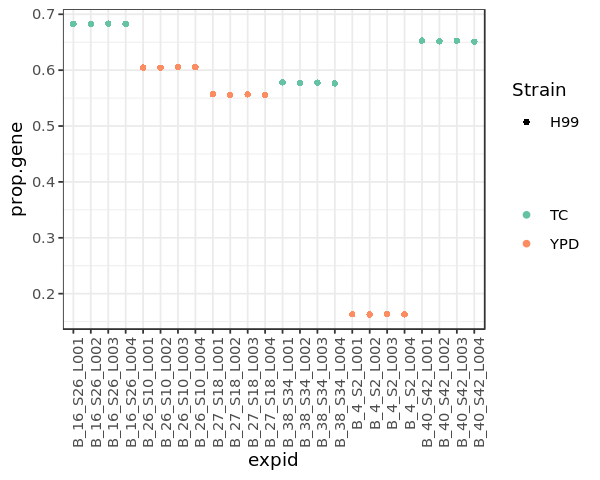

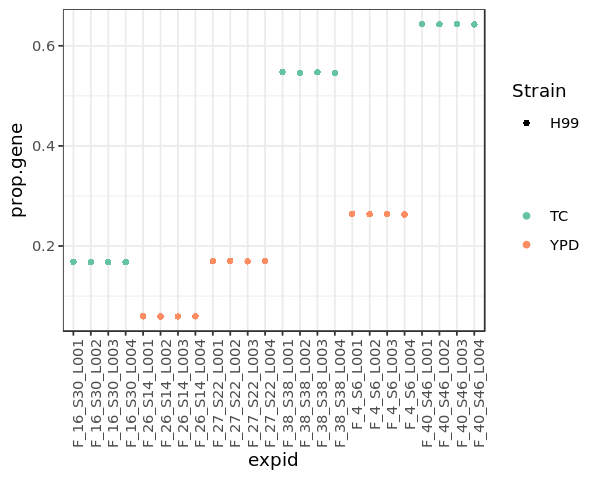

In [31]:
options(repr.plot.width = 5, repr.plot.height = 4)
tmp <- annomapres %>% filter(grepl("B", group)) %>% mutate(expid = str_replace(expid, "_ReadsPerGene.out.tab", ""))
tmp %>% select(Label, Media, Strain) %>% distinct %>% arrange(Media) %>% head(10)
gp <- ggplot(tmp, 
             aes(x = expid, 
                 y = prop.gene, 
                 shape = Strain, 
                 color = Media)) +
        #myfacet +
        geom_point() +
        mytheme + 
        mypal
  
print(gp)

tmp <- annomapres %>% filter(grepl("F", group)) %>% mutate(expid = str_replace(expid, "_ReadsPerGene.out.tab", ""))
tmp %>% select(Label, Media, Strain) %>% distinct %>% arrange(Media) %>% head(10)
gp <- ggplot(tmp, 
             aes(x = expid, 
                 y = prop.gene, 
                 shape = Strain, 
                 color = Media)) +
        #myfacet +
        geom_point() +
        mytheme + 
        mypal
print(gp)

### Show the fraction of unique mapped reads among all reads (prop.unique)

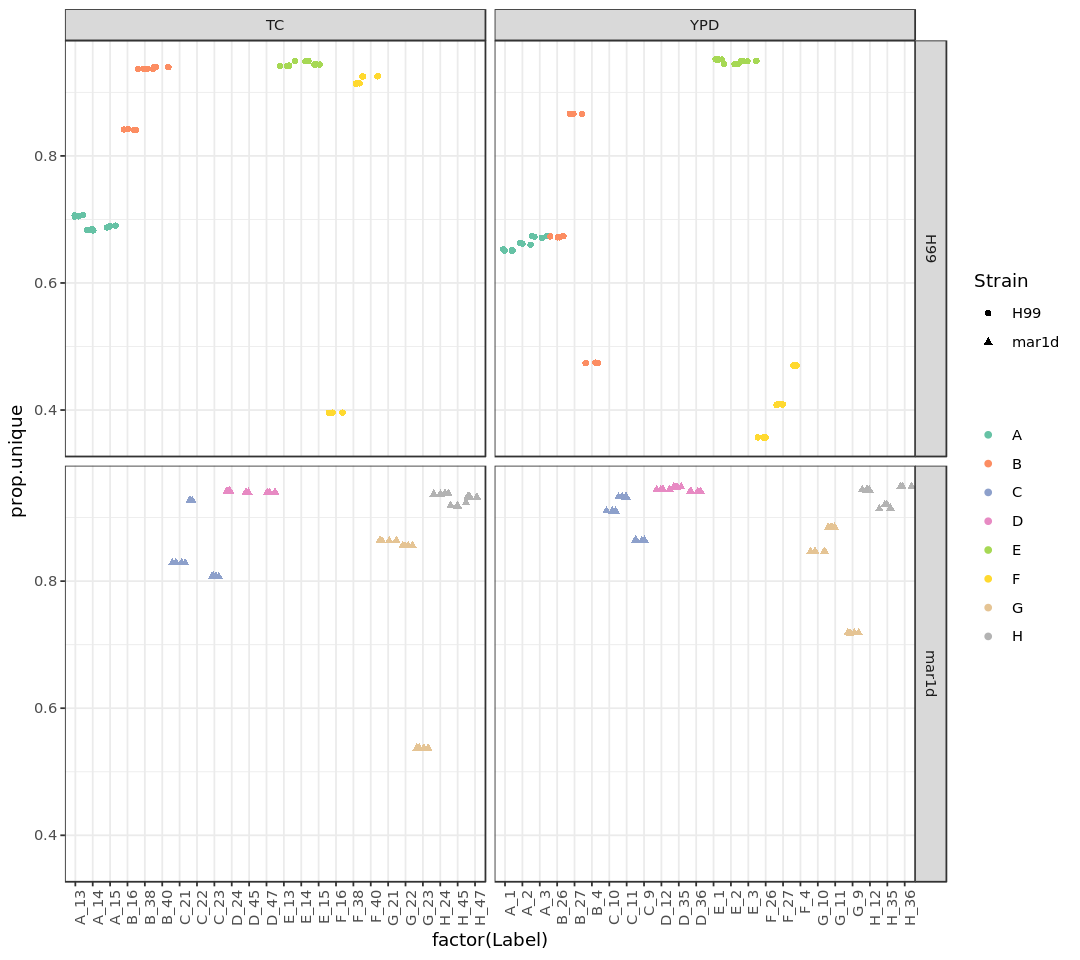

In [10]:
p1 <- ggplot(annomapres, 
             aes(x = factor(Label), 
                 y = prop.unique, 
                 shape = Strain, 
                 color = group)) +
        myfacet + 
        mygeom + 
        mytheme + 
        mypal

print(p1)

### Show the fraction of reads mapped to genes (prop.gene)

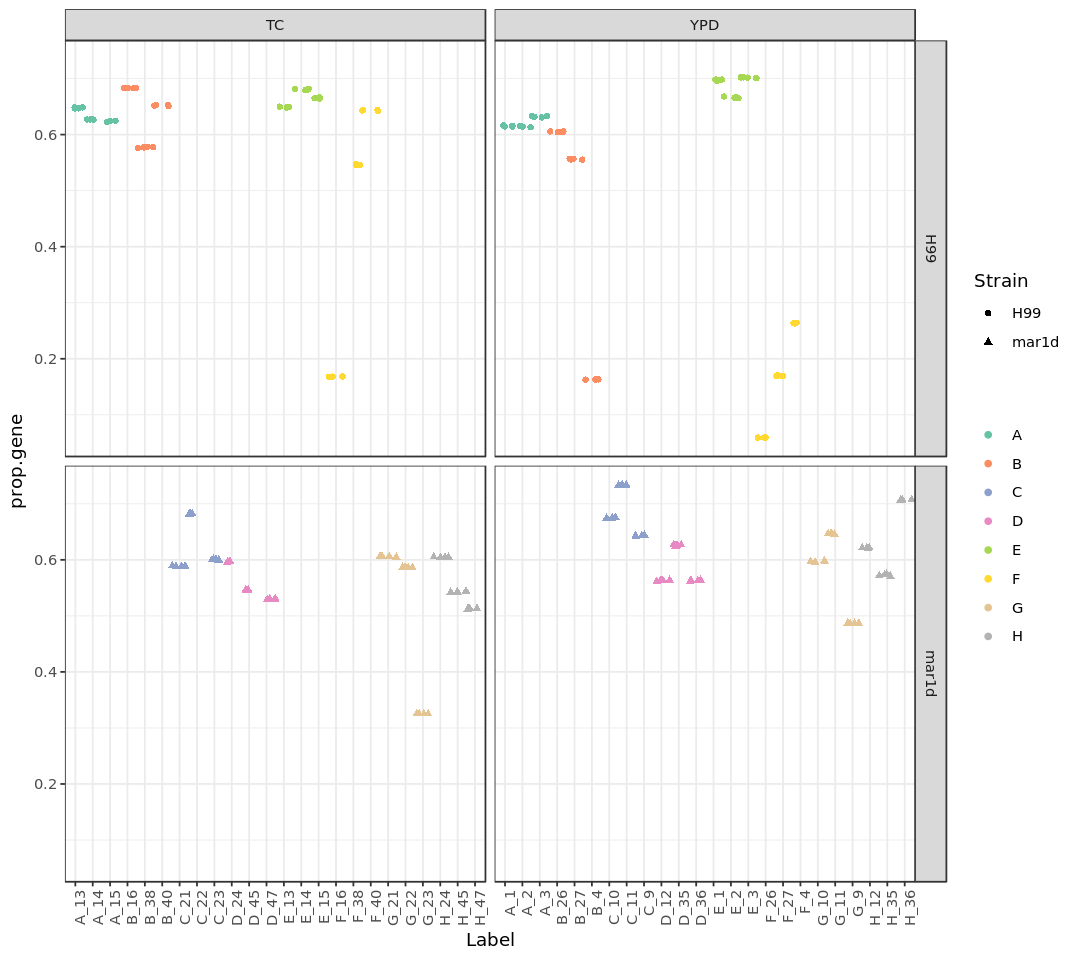

In [11]:
p2 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prop.gene, 
                 shape = Strain, 
                 color = group)) +
        myfacet +
        mygeom +
        mytheme + 
        mypal
  
print(p2)

### Show the fraction of reads categorized as "no feature" (prop.nofeat)

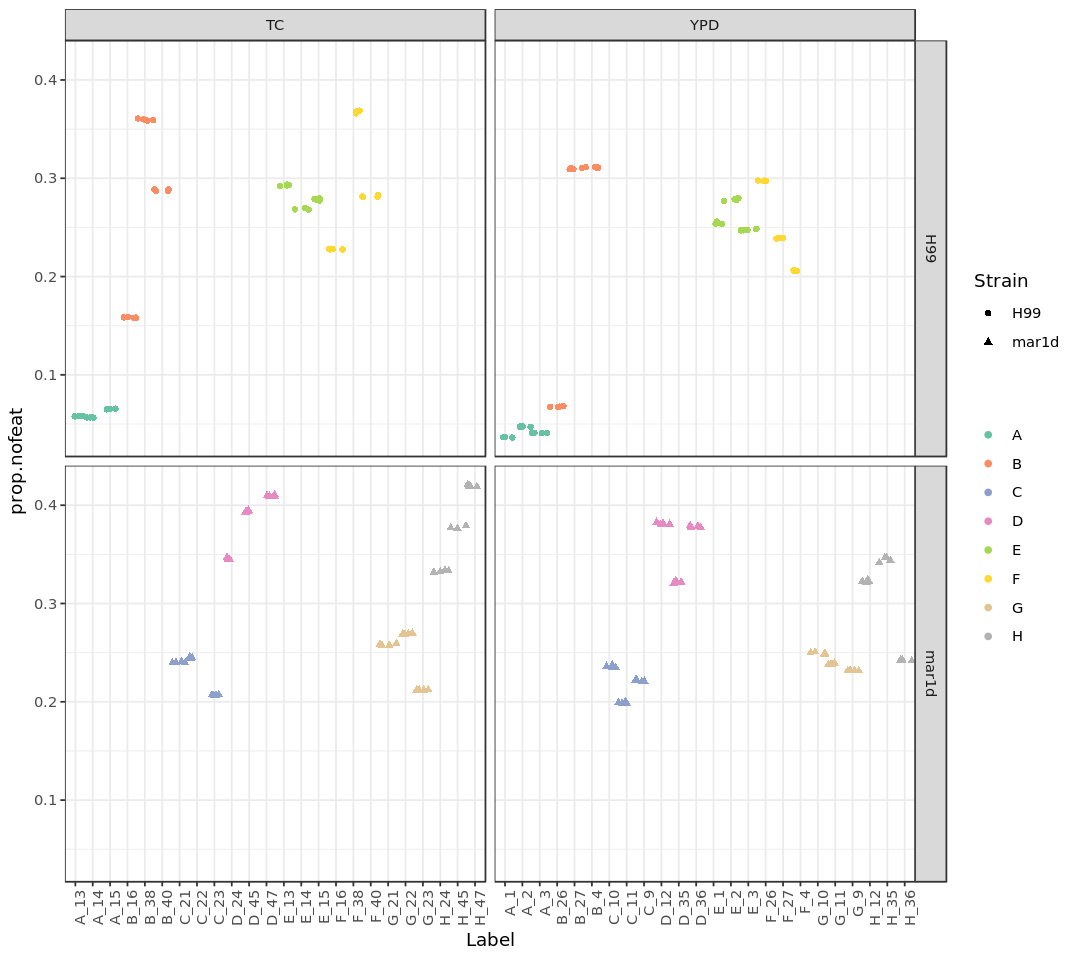

In [12]:
p3 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prop.nofeat, 
                 shape = Strain, 
                 color = group))+
        myfacet +
        mygeom + 
        mytheme + 
        mypal

print(p3)

### Show the number of all the reads in each sample 
(Note: depth = ngenemap + namb + nmulti + nnofeat + nunmap)

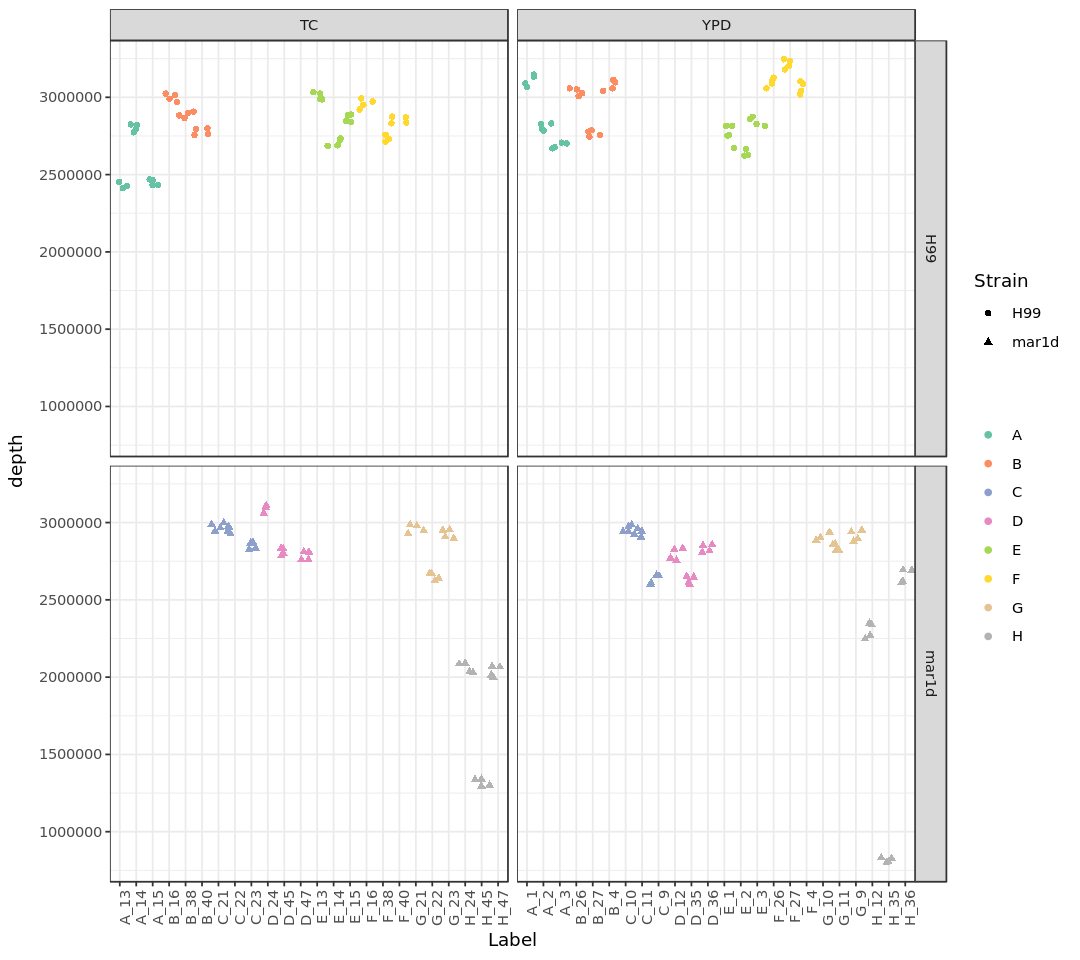

In [13]:
p4 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = depth, 
                 shape = Strain, 
                 color = group))+
        myfacet +
        mygeom +
        mytheme +
        mypal

print(p4)

### Store the plots

In [14]:
png(file.path("p1.png"), height = 480 * 2, width = 480 * 2)
plot(p1)
graphics.off()

png(file.path("p2.png"), height = 480 * 2, width = 480 * 2)
plot(p2)
graphics.off()

png(file.path("p3.png"), height = 480 * 2, width = 480 * 2)
plot(p3)
graphics.off()

png(file.path("p4.png"), height = 480 * 2, width = 480 * 2)
plot(p4)
graphics.off()

In [36]:
png(file.path(IMGDIR, "p1.png"), height = 480 * 1, width = 480 * 2)
plot(p1)
graphics.off()

png(file.path(IMGDIR, "p2.png"), height = 480 * 1, width = 480 * 2)
plot(p2)
graphics.off()

png(file.path(IMGDIR, "p3.png"), height = 480 * 1, width = 480 * 2)
plot(p3)
graphics.off()

png(file.path(IMGDIR, "p4.png"), height = 480 * 1, width = 480 * 2)
plot(p4)
graphics.off()

In [37]:
dir(IMGDIR)

[1] "p1.png" "p2.png" "p3.png" "p4.png"

# The End

In [38]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

Matrix products: default
BLAS: /opt/conda/lib/R/lib/libRblas.so
LAPACK: /opt/conda/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2               plotly_4.8.0              
 [3] dendextend_1.8.0           gridExtra_2.3             
 [5] RColorBrewer_1.1-2         qvalue_2.10.0             
 [7] limma_3.34.9               DESeq2_1.18.1             
 [9] SummarizedExperi